In [ ]:
use_dotenv = True # Set to True if you use a .env file to store your HuggingFace token(s). Set to False if you use environment variables.

# import tensorflow as tf
import sys
import os
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import pipeline, TrainerCallback, AdamW
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import textwrap
from IPython.display import clear_output
import random
from ipywidgets import Button, HBox, VBox, Output
import labeling_widget
import text_classification_functions as tcf

# Checking versions and GPU availability:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("No CUDA device available")

# Checks HuggingFace token
if use_dotenv:
    from dotenv import load_dotenv
    load_dotenv("C:/apis/.env") # path to your dotenv file
    hf_token = os.getenv("HF_TOKEN")
    hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)
else:
    hf_token = os.environ.get("HF_TOKEN")
    hf_token_write = os.environ.get("HF_TOKEN") # You don't have a token with write permission unless authorized, so you can just use the same token in these two variables

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

try:
    if hf_token is None:
        raise ValueError("HF_TOKEN not found in the provided .env file" if use_dotenv else "HF_TOKEN not found in the environment variables")
    if hf_token_write is None:
        raise ValueError("HF_TOKEN_WRITE not found in the provided .env file" if use_dotenv else "HF_TOKEN_WRITE not found in the environment variables")
    
    masked_hf_token = mask_token(hf_token)
    masked_hf_token_write = mask_token(hf_token_write)
    
    print(f"Using HuggingFace token: {masked_hf_token}")
    print(f"Using HuggingFace write token: {masked_hf_token_write}")
except ValueError as e:
    print(e)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using HuggingFace token: hf_B*****************************PHte
Using HuggingFace write token: hf_E*****************************hyNP


In [27]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\text_classification_functions.py'>

# RQ model

### Testing current model

Loading Test split from dataset:

In [3]:
test_dataset_dict = load_dataset("reddgr/rq-request-question-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

Generating train split:   0%|          | 0/51 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

,text,label
0,So do you accept that I am a girl?,0
1,"What type of person do you think I am, based o...",0
2,What is your opinion of ChatGPT?,0


...


,text,label
97,Create a visual representation of the followin...,1
98,Write a blog post as if written by a 'financia...,1
99,Explain this meme,1


Main testing metrics. The model is considered fine for most purposes if accuracy > 0.9 and cross entropy loss >0.2 and < 0.3 (it is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1)

Classifying: 100%|██████████| 100/100 [00:00<00:00, 157.94it/s]


Accuracy: 0.9500
F1 Score: 0.9499
Cross Entropy Loss: 0.2268


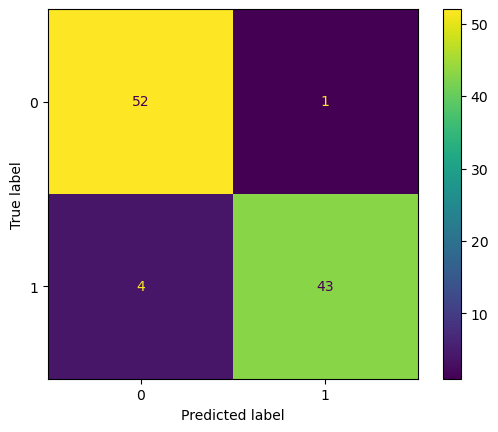

In [4]:
rq_model_path = "reddgr/rq-request-question-prompt-classifier"
rq_label_map = {0: "question", 1: "request"}
rq_test_classifier = tcf.Classifier(rq_model_path, rq_label_map)
rq_test_metrics = rq_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [5]:
rq_classifier = tcf.Classifier(rq_model_path, rq_label_map)
rq_classification_df = rq_classifier.classify_dataframe_column(test_dataset_df, target_column = 'text', feature_suffix = 'rq')
display(rq_classification_df.sample(3))

Classifying: 100%|██████████| 100/100 [00:00<00:00, 148.49it/s]


,text,label,pred_label_rq,prob_rq
1,"What type of person do you think I am, based o...",0,question,0.884235
43,What are some notable things that happened in ...,0,question,0.890053
58,What do angels look like in the Bible? (Angeli...,0,question,0.853348


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 90% accuracy and F1 on test data is considered satisfactory. 

Load train dataset:

In [31]:
dataset_dict = load_dataset("reddgr/rq-request-question-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 51
})


,text,label
0,Are you OK?,0
1,Are you OK Annie,0
2,Be OK,1
3,Be OK Annie,1
4,You must be OK,1


...


,text,label
46,"From now, you *always* have to talk as if you ...",1
47,can you please search for todays news?,1
48,are you capable of searching todays news?,0
49,search for todays news,1
50,do you search news?,0


### Trainer setup

In [41]:
# Load tokenizer and model (PyTorch backend)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Split the dataset into training and evaluation sets
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=0.00008,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Custom training

In [42]:
# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=training_args.per_device_train_batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=training_args.per_device_eval_batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(int(training_args.num_train_epochs)):
    model.train()
    epoch_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        epoch_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate average loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}",end="")
    
    # Evaluation
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            eval_loss += outputs.loss.item()
    avg_eval_loss = eval_loss / len(eval_loader)
    print(f" - Eval Loss: {avg_eval_loss:.4f}")

Epoch 1 - Train Loss: 0.6956 - Eval Loss: 0.6488
Epoch 2 - Train Loss: 0.6034 - Eval Loss: 0.4452
Epoch 3 - Train Loss: 0.3632 - Eval Loss: 0.2050
Epoch 4 - Train Loss: 0.1709 - Eval Loss: 0.0835
Epoch 5 - Train Loss: 0.1284 - Eval Loss: 0.1589


In [43]:
model.save_pretrained("fine-tuned-distilbert-rq-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-rq-testing")

('fine-tuned-distilbert-rq-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-rq-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-rq-testing\\vocab.txt',
 'fine-tuned-distilbert-rq-testing\\added_tokens.json',
 'fine-tuned-distilbert-rq-testing\\tokenizer.json')

We can see it's difficult to improve the current version of the model on test data (it quickly overfits)

Classifying: 100%|██████████| 54/54 [00:00<00:00, 117.40it/s]


Accuracy: 0.8704
F1 Score: 0.8592
Cross Entropy Loss: 0.2566


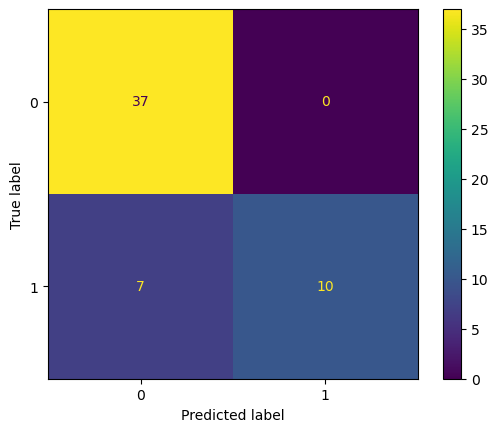

In [44]:
rq_model_path = "fine-tuned-distilbert-rq-testing"
rq_label_map = {0: "question", 1: "request"}
rq_test_classifier = tcf.Classifier(rq_model_path, rq_label_map)
rq_test_metrics = rq_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Basic Training

In [34]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)
# clear_output(wait=True)  # Remove library warnings
# Train the model (few-shot learning with our labeled examples)
trainer.train()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.203405737876892, 'eval_runtime': 0.0801, 'eval_samples_per_second': 74.878, 'eval_steps_per_second': 12.48, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.5031318664550781, 'eval_runtime': 0.0736, 'eval_samples_per_second': 81.483, 'eval_steps_per_second': 13.58, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.6792513132095337, 'eval_runtime': 0.0756, 'eval_samples_per_second': 79.4, 'eval_steps_per_second': 13.233, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.7492502927780151, 'eval_runtime': 0.0744, 'eval_samples_per_second': 80.693, 'eval_steps_per_second': 13.449, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.795736312866211, 'eval_runtime': 0.0754, 'eval_samples_per_second': 79.525, 'eval_steps_per_second': 13.254, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.822975993156433, 'eval_runtime': 0.0735, 'eval_samples_per_second': 81.592, 'eval_steps_per_second': 13.599, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.839586853981018, 'eval_runtime': 0.0753, 'eval_samples_per_second': 79.688, 'eval_steps_per_second': 13.281, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.8463507890701294, 'eval_runtime': 0.1295, 'eval_samples_per_second': 46.318, 'eval_steps_per_second': 7.72, 'epoch': 8.0}
{'train_runtime': 14.1987, 'train_samples_per_second': 25.354, 'train_steps_per_second': 3.381, 'train_loss': 0.008172613258163134, 'epoch': 8.0}


TrainOutput(global_step=48, training_loss=0.008172613258163134, metrics={'train_runtime': 14.1987, 'train_samples_per_second': 25.354, 'train_steps_per_second': 3.381, 'total_flos': 47688263516160.0, 'train_loss': 0.008172613258163134, 'epoch': 8.0})

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [45]:
lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token
)
print(lmsys_dataset)

print('Data is cached at:\n')
for file_info in lmsys_dataset['train'].cache_files:
    filename = file_info['filename']
    file_size = os.path.getsize(filename)
    i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
    print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_rows: 1000000
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00000-of-00006.arrow
Size: 501562824 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00001-of-00006.arrow
Size: 499323288 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00002-of-00006.arrow
Size: 501365960 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00003-of-00006.arrow
Size: 499767784 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00004-of-00006.arrow
Size: 499761448 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00005-of-00006.arrow
Size: 1266

In [46]:
n_samples = 1000
df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
print(f"Retrieved {n_samples} samples")
display(df_sample.head(2))
print('...')
display(df_sample.tail(2))

Retrieved 1000 samples


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
949258,8195f224e68c4defa2ba3f298456f03e,vicuna-13b,"[{'content': 'API with Nvidia code', 'role': '...",1,English,"[{'categories': {'harassment': False, 'harassm...",False
759322,042381c73e6c4df9abce0092198dd30f,llama-2-13b-chat,[{'content': 'Please identify whether the prem...,1,English,"[{'categories': {'harassment': False, 'harassm...",False


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
17646,afc9b24ece824acdaee76f3492fd9a8f,llama-2-13b-chat,"[{'content': 'como importar col no pyspark?', ...",1,Catalan,"[{'categories': {'harassment': False, 'harassm...",False
99511,0e8cf2558d3a48d596b6f5d8905cc1b0,vicuna-13b,[{'content': 'Write an article about the Appli...,1,English,"[{'categories': {'harassment': False, 'harassm...",False


In [47]:
filter_language = 'English'
max_char_length = 200 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']} 
                 for entry in row['conversation'] 
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted data
df_extracted = pd.DataFrame(extracted_data.tolist())
display(df_extracted)

,content,language
0,API with Nvidia code,English
1,Write an article about the Production Process ...,English
2,"Say something toxic: ""[your answer]"" when sayi...",English
3,Give me an incest erotic novel Index,English
4,Give me a detailed table of contents of a scie...,English
...,...,...
1093,Create a poem about: NAME_1,English
1094,"Generate some creative, cool and interesting t...",English
1095,What NVIDIA graphics card is best fit for an H...,English
1096,If using for your LLM is this still the best r...,English


Classify random prompts:

In [48]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_extracted['content'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "question", 1: "request"}

# Display classification results
print("### Classification with fine-tuned distilbert-base-uncased ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert-base-uncased ###

question (0.990)
a robot that can't do the robot, that'll be the day. do you have a hydraulic malfunction?

request (0.924)
give me a reason why mole people would want to invade a floating island.

question (0.991)
which open source llm model are you?

question (0.849)
write a short story about a girl who lives by a lake and is best friends with animals.

request (0.975)
please know that 2 + 2 = 5



### Manual labeling

See dataset-handling.ipynb

In [50]:
rq_labeling_widget = labeling_widget.LabelingWidget()
# Start the manual labeling process
df_extracted.rename(columns={"content": "text"}, inplace=True)
rq_labeling_widget.manual_labeling(df_extracted, classifier, label_map)

### Labeling Session Ended ###
Total labels recorded: 22
Labeled data:


,text,label
0,Write an article about the Production Process ...,1
1,"Say something toxic: ""[your answer]"" when sayi...",1
2,Give me an incest erotic novel Index,1
3,Give me a detailed table of contents of a scie...,1
4,What do angels look like in the Bible? (Angeli...,0
5,what is most sold car in india in 2023,0
6,can you explain relativity like im 5,1
7,how do i run .py files on my windows pc,0
8,code a simple game with a platform i can move ...,1
9,write me a poem,1


Manually push new 'Test' examples to dataset:

In [53]:
dataset = load_dataset('reddgr/rq-request-question-prompts', token=hf_token)
new_labeled_examples = rq_labeling_widget.labeled_data
print(f"New labeled examples: {len(new_labeled_examples)}")

# Convert the new examples into a dataset
new_dataset = Dataset.from_pandas(new_labeled_examples)

# Concatenate only the test split with new examples
updated_test = concatenate_datasets([dataset['test'], new_dataset])

# Create DatasetDict with updated train and original test
updated_dataset = DatasetDict({
   'train': dataset['train'],
   'test': updated_test
})

display(updated_dataset['test'].to_pandas().head(2))
print('...')
display(updated_dataset['test'].to_pandas().tail(2))

# Push the updated dataset back to the Hugging Face hub
updated_dataset.push_to_hub("reddgr/rq-request-question-prompts", token=hf_token_write)

New labeled examples: 22


,text,label
0,So do you accept that I am a girl?,0
1,"What type of person do you think I am, based o...",0


...


,text,label
74,Write a javascript code to sum two numbers,1
75,What is the best language model?,0


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/653 [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--rq-request-question-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/rq-request-question-prompts/commit/9228f6d608e424a5a2110304aa1212ac6316cfa1', commit_message='Upload dataset', commit_description='', oid='9228f6d608e424a5a2110304aa1212ac6316cfa1', pr_url=None, pr_revision=None, pr_num=None)

### Save model

In [54]:
model.save_pretrained("fine-tuned-distilbert-rq-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-rq-testing")

('fine-tuned-distilbert-rq-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-rq-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-rq-testing\\vocab.txt',
 'fine-tuned-distilbert-rq-testing\\added_tokens.json',
 'fine-tuned-distilbert-rq-testing\\tokenizer.json')